In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.circuit.library import ZFeatureMap, EfficientSU2
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp

In [ ]:

N_QUBITS = 4
N_LAYERS = 3
TARGET_ACCURACY = 0.80
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


DIGITS_TO_CLASSIFY = [0, 1]
N_INITIAL_SAMPLES = 20
TOTAL_QUERY_BATCH_SIZE = 10 
ACTIVE_BATCH_SIZE = 200     
BATCH_SIZE_TRAIN = 10


LEARNING_RATE = 0.01
N_INITIAL_EPOCHS = 50       
N_FINETUNE_EPOCHS = 2       

## Now we will start the pre-processing
Here we will load MNIST dataset, Apply PCA and then divide by the digits to classify:

$$ [0,1]$$

In [9]:
def load_and_preprocess_data():
    
    print("Loading and preprocessing data...")
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    y = y.astype(int)

    mask = np.isin(y, DIGITS_TO_CLASSIFY)
    X_filtered = X[mask]
    y_filtered = y[mask]
    y_mapped = np.where(y_filtered == DIGITS_TO_CLASSIFY[0], 0, 1)

    X_scaled = X_filtered / 255.0 
    pca = PCA(n_components=N_QUBITS)
    X_pca = pca.fit_transform(X_scaled)

    X_pool, X_test, y_pool, y_test = train_test_split(
        X_pca, y_mapped, 
        test_size=0.3, random_state=RANDOM_SEED, stratify=y_mapped
    )
    
    print(f"Data processed succecfully. Pool: {len(y_pool)} samples. Test: {len(y_test)} samples.")
    return X_pool, y_pool, X_test, y_test


## Hybrid Model (QNN)

In [ ]:
class HybridQNN(nn.Module):
    
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        
        feature_map = ZFeatureMap(n_qubits)
        ansatz = EfficientSU2(n_qubits, reps=n_layers)
        
        qc = QuantumCircuit(n_qubits)
        qc.compose(feature_map, inplace=True)
        qc.compose(ansatz, inplace=True)
        
        pauli_string = "I" * (n_qubits - 1) + "Z" 
        observable = SparsePauliOp(pauli_string)
        
        estimator = Estimator()

        qnn = EstimatorQNN(
            circuit=qc,
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            estimator=estimator,
        )

        self.q_layer = TorchConnector(
            qnn,
            
            initial_weights=np.random.rand(ansatz.num_parameters),
        )
        
        self.c_layer = nn.Linear(1, 2) 

    def forward(self, x):
        x = self.q_layer(x)
        x = self.c_layer(x)
        return x


In [10]:
def run_simulation(config_name, n_passive_per_batch, n_active_per_batch, X_pool, y_pool, X_test_tensor, y_test_tensor, initial_indices, initial_model_state):
   
    
    print(f"\n--- Iniciando Simulação: {config_name} ({n_passive_per_batch}P + {n_active_per_batch}A) ---")
    
    # Criar cópias dos dados
    local_X_pool = np.copy(X_pool)
    local_y_pool = np.copy(y_pool)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TRAIN)

    
    labeled_X_pca = [torch.tensor(local_X_pool[i], dtype=torch.float32) for i in initial_indices]
    labeled_y = [torch.tensor(local_y_pool[i], dtype=torch.long) for i in initial_indices]
    
    unlabeled_indices = np.array(list(set(range(len(local_y_pool))) - set(initial_indices)))
    
    
    model = HybridQNN(N_QUBITS, N_LAYERS)
    model.load_state_dict(initial_model_state) 
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    
    current_accuracy = 0.0
    history = [] 
    
    while current_accuracy < TARGET_ACCURACY and len(unlabeled_indices) > 0:
        
        # 5.1. Avaliar
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        current_accuracy = correct / total
        n_labeled = len(labeled_y)
        history.append((n_labeled, current_accuracy))
        print(f"[{config_name}] Rótulos: {n_labeled:4d} | Precisão: {current_accuracy:.4f}")

        if current_accuracy >= TARGET_ACCURACY:
            break
            
        
        new_labels_pca = []
        new_labels_y = []
        indices_to_remove = []
        
        current_unlabeled_indices = np.copy(unlabeled_indices) 

        
        n_to_query_passive = min(n_passive_per_batch, len(current_unlabeled_indices))
        if n_to_query_passive > 0:
            
            passive_indices = np.random.choice(current_unlabeled_indices, n_to_query_passive, replace=False)
            
            for idx in passive_indices:
                new_labels_pca.append(torch.tensor(local_X_pool[idx], dtype=torch.float32))
                new_labels_y.append(torch.tensor(local_y_pool[idx], dtype=torch.long))
                indices_to_remove.append(idx)
            
            mask_to_remove_passive = np.isin(current_unlabeled_indices, passive_indices)
            current_unlabeled_indices = current_unlabeled_indices[~mask_to_remove_passive]

        
        n_to_query_active = min(n_active_per_batch, len(current_unlabeled_indices))
        if n_to_query_active > 0:
            
            n_to_check = min(ACTIVE_BATCH_SIZE, len(current_unlabeled_indices))
            if n_to_check == 0:
                break
                
            batch_indices_relative = np.random.choice(range(len(current_unlabeled_indices)), n_to_check, replace=False)
            batch_indices_absolute = current_unlabeled_indices[batch_indices_relative]
            
            X_U_batch_pca = torch.tensor(local_X_pool[batch_indices_absolute], dtype=torch.float32)
            
            with torch.no_grad():
                outputs = model(X_U_batch_pca)
                probs = torch.softmax(outputs, dim=1)
            
            uncertainty = torch.abs(probs[:, 0] - probs[:, 1])
            most_uncertain_indices_relative = torch.argsort(uncertainty)[:n_to_query_active]
            
            active_indices_raw = batch_indices_absolute[most_uncertain_indices_relative]
            active_indices = np.atleast_1d(active_indices_raw) # Correção do bug anterior

            for idx in active_indices:
                new_labels_pca.append(torch.tensor(local_X_pool[idx], dtype=torch.float32))
                new_labels_y.append(torch.tensor(local_y_pool[idx], dtype=torch.long))
                indices_to_remove.append(idx)

       
        labeled_X_pca.extend(new_labels_pca)
        labeled_y.extend(new_labels_y)
        
        
        mask_to_remove_all = np.isin(unlabeled_indices, indices_to_remove)
        unlabeled_indices = unlabeled_indices[~mask_to_remove_all]
        
        
        train_dataset = TensorDataset(torch.stack(labeled_X_pca), torch.stack(labeled_y))
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
        
        model.train()
        for epoch in range(N_FINETUNE_EPOCHS):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
            
    print(f"--- Simulação {config_name} Concluída ---")
    return history

# Main Script

In [11]:
if __name__ == "__main__":
    
    
    X_pool, y_pool, X_test_np, y_test_np = load_and_preprocess_data()
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

    
    print("\n--- A criar o ponto de partida comum (Treino Inicial) ---")
    
    
    initial_indices = np.random.choice(range(len(y_pool)), N_INITIAL_SAMPLES, replace=False)
    
    
    labeled_X_pca = [torch.tensor(X_pool[i], dtype=torch.float32) for i in initial_indices]
    labeled_y = [torch.tensor(y_pool[i], dtype=torch.long) for i in initial_indices]
    
    train_dataset = TensorDataset(torch.stack(labeled_X_pca), torch.stack(labeled_y))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
    
    
    initial_model = HybridQNN(N_QUBITS, N_LAYERS)
    optimizer = optim.Adam(initial_model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    
    initial_model.train()
    for epoch in range(N_INITIAL_EPOCHS):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = initial_model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
    
    initial_model_state = initial_model.state_dict()
    print("--- Ponto de partida criado. A iniciar as 11 simulações. ---")
    
    
    configurations = []
    for n_active in range(TOTAL_QUERY_BATCH_SIZE + 1): # De 0 a 10
        n_passive = TOTAL_QUERY_BATCH_SIZE - n_active
        config_name = f"({n_passive}P + {n_active}A)"
        configurations.append((config_name, n_passive, n_active))
    
    results = {}

    print("\nAVISO: As 11 simulações vão começar. Isto pode demorar várias horas.")
    start_time_total = time.time()

    for name, n_p, n_a in configurations:
        start_time_sim = time.time()
        
        history = run_simulation(
            name, n_p, n_a, 
            X_pool, y_pool, X_test_tensor, y_test_tensor,
            initial_indices, initial_model_state
        )
        results[name] = history
        print(f"Tempo da simulação {name}: {(time.time() - start_time_sim)/60:.2f} minutos")

    print(f"\n--- EXPERIÊNCIA COMPLETA CONCLUÍDA ---")
    print(f"Tempo total: {(time.time() - start_time_total)/60:.2f} minutos")

    
    plt.figure(figsize=(14, 9))
    
    for name, history in results.items():
        if history:
            x_data, y_data = zip(*history)
            plt.plot(x_data, y_data, 'o-', label=name, markersize=4, alpha=0.8)

    plt.axhline(y=TARGET_ACCURACY, color='gray', linestyle=':', label=f"{TARGET_ACCURACY * 100}% Target")
    plt.xlabel("Número Total de Rótulos")
    plt.ylabel("Precisão no Conjunto de Teste")
    plt.title("Comparação de Estratégias de Active Learning (Qiskit+PyTorch)")
    plt.legend(title="Estratégia (Passivo + Ativo)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Loading and preprocessing data...
Data processed succecfully. Pool: 10346 samples. Test: 4434 samples.

--- A criar o ponto de partida comum (Treino Inicial) ---


/var/folders/rs/wmb9tlw54_57w8bqd4qxp_zh0000gn/T/ipykernel_2644/228944700.py:16: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/var/folders/rs/wmb9tlw54_57w8bqd4qxp_zh0000gn/T/ipykernel_2644/228944700.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


KeyboardInterrupt: 

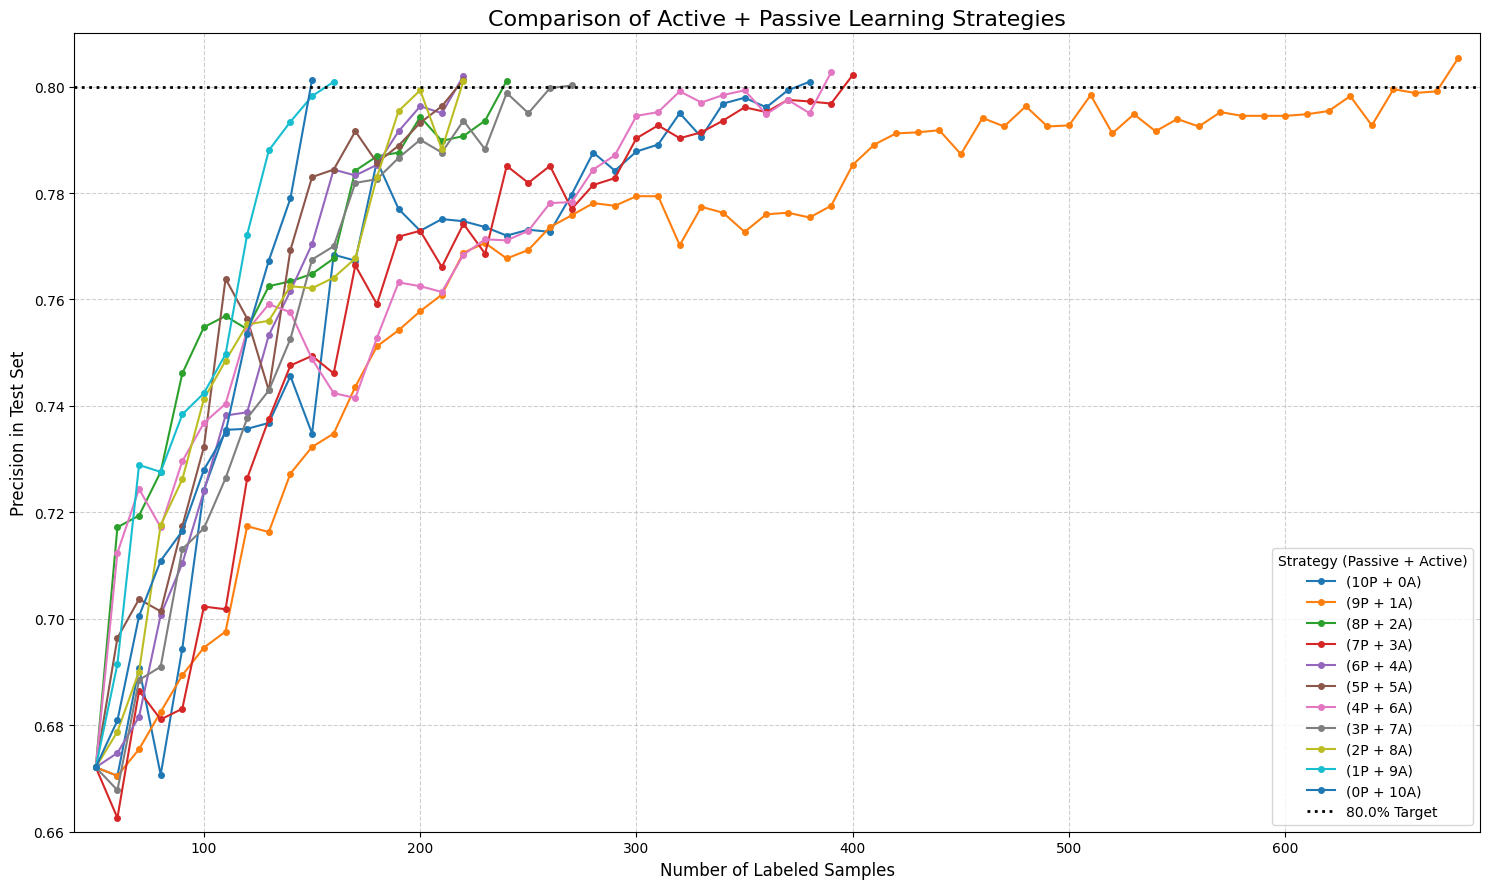

In [12]:
# 1. Dados extraídos dos teus logs
data = {
    '(10P + 0A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380],
        'precision': [0.6721, 0.6705, 0.6908, 0.6707, 0.6944, 0.7242, 0.7355, 0.7357, 0.7368, 0.7456, 0.7348, 0.7684, 0.7673, 0.7860, 0.7770, 0.7729, 0.7751, 0.7747, 0.7736, 0.7720, 0.7731, 0.7727, 0.7797, 0.7876, 0.7842, 0.7878, 0.7891, 0.7950, 0.7905, 0.7968, 0.7979, 0.7961, 0.7993, 0.8009]
    },
    '(9P + 1A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680],
        'precision': [0.6721, 0.6705, 0.6755, 0.6825, 0.6894, 0.6946, 0.6976, 0.7174, 0.7163, 0.7273, 0.7323, 0.7348, 0.7436, 0.7512, 0.7542, 0.7578, 0.7609, 0.7688, 0.7706, 0.7677, 0.7693, 0.7736, 0.7758, 0.7781, 0.7776, 0.7794, 0.7794, 0.7702, 0.7774, 0.7763, 0.7727, 0.7760, 0.7763, 0.7754, 0.7776, 0.7853, 0.7891, 0.7912, 0.7914, 0.7918, 0.7873, 0.7941, 0.7925, 0.7963, 0.7925, 0.7927, 0.7984, 0.7912, 0.7948, 0.7916, 0.7939, 0.7925, 0.7952, 0.7945, 0.7945, 0.7945, 0.7948, 0.7954, 0.7982, 0.7927, 0.7995, 0.7988, 0.7991, 0.8054]
    },
    '(8P + 2A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240],
        'precision': [0.6721, 0.7172, 0.7194, 0.7276, 0.7461, 0.7548, 0.7569, 0.7544, 0.7625, 0.7634, 0.7648, 0.7677, 0.7842, 0.7869, 0.7876, 0.7943, 0.7898, 0.7907, 0.7936, 0.8011]
    },
    '(7P + 3A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400],
        'precision': [0.6721, 0.6626, 0.6865, 0.6811, 0.6831, 0.7023, 0.7018, 0.7264, 0.7375, 0.7476, 0.7494, 0.7461, 0.7664, 0.7591, 0.7718, 0.7729, 0.7661, 0.7742, 0.7686, 0.7851, 0.7819, 0.7851, 0.7770, 0.7815, 0.7828, 0.7903, 0.7927, 0.7903, 0.7914, 0.7936, 0.7961, 0.7952, 0.7975, 0.7972, 0.7968, 0.8022]
    },
    '(6P + 4A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220],
        'precision': [0.6721, 0.6748, 0.6816, 0.7007, 0.7104, 0.7240, 0.7382, 0.7388, 0.7533, 0.7616, 0.7704, 0.7844, 0.7833, 0.7853, 0.7916, 0.7963, 0.7950, 0.8020]
    },
    '(5P + 5A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220],
        'precision': [0.6721, 0.6964, 0.7037, 0.7014, 0.7174, 0.7323, 0.7639, 0.7564, 0.7429, 0.7693, 0.7830, 0.7844, 0.7916, 0.7857, 0.7889, 0.7932, 0.7963, 0.8013]
    },
    '(4P + 6A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390],
        'precision': [0.6721, 0.7124, 0.7244, 0.7172, 0.7296, 0.7368, 0.7404, 0.7542, 0.7591, 0.7576, 0.7488, 0.7424, 0.7415, 0.7528, 0.7632, 0.7625, 0.7614, 0.7684, 0.7713, 0.7711, 0.7729, 0.7781, 0.7783, 0.7844, 0.7871, 0.7945, 0.7952, 0.7991, 0.7970, 0.7984, 0.7993, 0.7948, 0.7975, 0.7950, 0.8027]
    },
    '(3P + 7A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270],
        'precision': [0.6721, 0.6678, 0.6885, 0.6910, 0.7131, 0.7170, 0.7264, 0.7377, 0.7429, 0.7526, 0.7675, 0.7700, 0.7819, 0.7826, 0.7866, 0.7900, 0.7876, 0.7936, 0.7882, 0.7988, 0.7950, 0.7997, 0.8002]
    },
    '(2P + 8A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220],
        'precision': [0.6721, 0.6788, 0.6901, 0.7176, 0.7262, 0.7413, 0.7485, 0.7553, 0.7560, 0.7625, 0.7621, 0.7641, 0.7677, 0.7830, 0.7954, 0.7993, 0.7882, 0.8011]
    },
    '(1P + 9A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
        'precision': [0.6721, 0.6915, 0.7289, 0.7276, 0.7384, 0.7424, 0.7497, 0.7722, 0.7880, 0.7934, 0.7982, 0.8009]
    },
    '(0P + 10A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
        'precision': [0.6721, 0.6809, 0.7005, 0.7109, 0.7165, 0.7280, 0.7350, 0.7535, 0.7673, 0.7790, 0.8013]
    }
}

# 2. Ordem das estratégias (para corresponder à legenda)
strategy_order = [
    '(10P + 0A)',
    '(9P + 1A)',
    '(8P + 2A)',
    '(7P + 3A)',
    '(6P + 4A)',
    '(5P + 5A)',
    '(4P + 6A)',
    '(3P + 7A)',
    '(2P + 8A)',
    '(1P + 9A)',
    '(0P + 10A)'
]

# 3. Criar o Gráfico
plt.figure(figsize=(15, 9)) # Define um bom tamanho para a figura

# 4. Plotar cada estratégia
for strategy_name in strategy_order:
    labels = data[strategy_name]['labels']
    precision = data[strategy_name]['precision']
    
    # Usar 'linestyle' e 'marker' para replicar o estilo do gráfico original
    plt.plot(labels, precision, linestyle='-', marker='.', markersize=8, label=strategy_name)

# 5. Adicionar Elementos de Estilo
# Título e Rótulos dos Eixos
plt.title('Comparison of Active + Passive Learning Strategies', fontsize=16)
plt.xlabel('Number of Labeled Samples', fontsize=12)
plt.ylabel('Precision in Test Set', fontsize=12)

# Linha da Meta (Target)
plt.axhline(y=0.8, color='black', linestyle=':', linewidth=2, label='80.0% Target')

# Grelha (Grid)
plt.grid(True, linestyle='--', alpha=0.6)

# Definir limites dos eixos (opcional, mas ajuda na visualização)
# Começa um pouco abaixo da precisão mais baixa e vai um pouco acima de 80%
plt.ylim(0.66, 0.81) 
# Começa no início e vai até ao máximo de rótulos do (9P + 1A)
plt.xlim(min(data['(10P + 0A)']['labels']) - 10, max(data['(9P + 1A)']['labels']) + 10) 

# Legenda
plt.legend(title='Strategy (Passive + Active)', loc='lower right', fontsize=10)

# 6. Mostrar o Gráfico
plt.tight_layout() # Ajusta o plot para evitar cortes
plt.show()